In [2]:
pip install tmdbsimple

  Obtaining dependency information for tmdbsimple from https://files.pythonhosted.org/packages/6c/dd/ade05d202db728b23e54aa0959622d090776023917e7308c1b2469a07b76/tmdbsimple-2.9.1-py3-none-any.whl.metadata
Using cached tmdbsimple-2.9.1-py3-none-any.whl (38 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Necessary imports
import pandas as pd
import seaborn as sns
import numpy as np
# We want all columns displayed, setting output to 50 to be safe
pd.set_option('display.max_columns',100)
import os, time, json
import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook

In [4]:
with open('/Users/Rovidicus/.secret/tmdb_api.json','r') as f:
    login=json.load(f)
login.keys()

dict_keys(['API Key', 'Access Token'])

In [5]:
import tmdbsimple as tmdb
tmdb.API_KEY = login['API Key']

In [6]:
basics=pd.read_csv('Data/basics.csv')
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama


In [7]:
FOLDER="Data/Hypothesis_Testing/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['.ipynb_checkpoints',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2002.csv.gz',
 'final_tmdb_data_2010.csv.gz',
 'final_tmdb_data_2020.csv.gz',
 'final_tmdb_data_2021.csv.gz',
 'final_tmdb_data_2022.csv.gz',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_2020.json',
 'tmdb_api_results_2021.json',
 'tmdb_api_results_2022.json',
 'tmdb_api_results_[2001, 2002].json',
 'tmdb_results_combined.csv.gz',
 'tmdb_results_postcovid.csv.gz']

In [8]:
def get_movie_with_rating(movie_id):
    movie = tmdb.Movies(movie_id)
    
    movie_info = movie.info()
    releases = movie.releases()
    
    for c in releases['countries']:
        if c['iso_3166_1' ] =='US':
            movie_info['certification'] = c['certification']
    return movie_info


def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        file_data = json.load(file)
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        file.seek(0)
        json.dump(file_data, file)

In [9]:
# We will retreive movie data on years from the pandemic to present
YEARS_TO_GET=list(range(2020, 2023))

In [11]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    JSON_FILE_YEAR = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    file_exists = os.path.isfile(JSON_FILE_YEAR)

    if file_exists == False:
        print(f'Creating{JSON_FILE_YEAR} for API results for year = {YEAR}.')
        with open (JSON_FILE_YEAR, 'w') as f:
            json.dump([{'imdb_id':0}],f)

    else:
        print(f'The file {JSON_FILE_YEAR} already exists.')

    df_year = basics.loc[basics['startYear'] == YEAR].copy()
    movie_ids = df_year['tconst']
        
        # Create an empty list to store movie information
    movie_info_list = []
    errors=[]    
        # Iterate over movie IDs for the current year
    for movie_id in tqdm_notebook(movie_ids, f'Movies from {YEAR}'):
        try:
            temp = get_movie_with_rating(movie_id)
            movie_info_list.append(temp)
            time.sleep(0.02)
        except Exception as e:
            errors.append([movie_id, e])
        
        # Write the movie information to the JSON file
    write_json(movie_info_list, JSON_FILE_YEAR)

    final_year_df2 = pd.read_json(JSON_FILE_YEAR)
    csv_fname = f'{FOLDER}final_tmdb_data_{YEAR}.csv.gz'
    final_year_df2.to_csv(csv_fname, compression='gzip', index=False)

YEARS:   0%|          | 0/3 [00:00<?, ?it/s]

The file Data/Hypothesis_Testing/tmdb_api_results_2020.json already exists.


Movies from 2020:   0%|          | 0/5010 [00:00<?, ?it/s]

The file Data/Hypothesis_Testing/tmdb_api_results_2021.json already exists.


Movies from 2021:   0%|          | 0/5163 [00:00<?, ?it/s]

The file Data/Hypothesis_Testing/tmdb_api_results_2022.json already exists.


Movies from 2022:   0%|          | 0/5073 [00:00<?, ?it/s]

In [12]:
import glob
# Use glob to get all filepaths that match the pattern (*=wildcard)
tmdb_files = sorted(glob.glob("Data/Hypothesis_Testing/final_tmdb_data*.csv.gz"))
tmdb_files

['Data/Hypothesis_Testing\\final_tmdb_data_2001.csv.gz',
 'Data/Hypothesis_Testing\\final_tmdb_data_2002.csv.gz',
 'Data/Hypothesis_Testing\\final_tmdb_data_2010.csv.gz',
 'Data/Hypothesis_Testing\\final_tmdb_data_2020.csv.gz',
 'Data/Hypothesis_Testing\\final_tmdb_data_2021.csv.gz',
 'Data/Hypothesis_Testing\\final_tmdb_data_2022.csv.gz']

In [13]:
# Use read_csv in a list comprehension and combine with concat to load all files
df = pd.concat([pd.read_csv(f) for f in tmdb_files] )
df.head(10)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,origin_country
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0096056,0.0,/95U3MUDXu4xSCmVLtWgargRipDi.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,109809.0,en,Crime and Punishment,A modern day adaptation of Dostoyevsky's class...,10.357,/2ckMQwDi11TofiNoaE3sHrYbaCh.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2002-06-01,0.0,126.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Crime and Punishment,0.0,5.385,13.0,NaN,NaN
2,tt0118926,0.0,/qR3Dk3ctnrrxkAI6I472RhamIbu.jpg,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,20689.0,en,The Dancer Upstairs,A police detective in a South American country...,8.475,/jG662jKzEf63fhcbbN3WiLlz5MX.jpg,"[{'id': 357, 'logo_path': None, 'name': 'Vía D...","[{'iso_3166_1': 'ES', 'name': 'Spain'}, {'iso_...",2002-09-20,5227348.0,132.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"An honest man caught in a world of intrigue, p...",The Dancer Upstairs,0.0,6.200,51.0,NaN,NaN
3,tt0119980,0.0,NaN,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,563364.0,en,Random Shooting in LA,The seamy side of Los Angeles is revealed thro...,0.600,/79sMfuJzskjBOB28dJyQ2VIBQsd.jpg,"[{'id': 111499, 'logo_path': None, 'name': 'Co...","[{'iso_3166_1': 'US', 'name': 'United States o...",2002-07-13,0.0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Random Shooting in LA,0.0,0.000,0.0,NaN,NaN
4,tt0120679,0.0,/s04Ds4xbJU7DzeGVyamccH4LoxF.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.miramax.com/movie/frida,1360.0,en,Frida,"A biography of artist Frida Kahlo, who channel...",15.753,/a4hgR6aKoohB6MHni171jbi9BkU.jpg,"[{'id': 14, 'logo_path': '/m6AHu84oZQxvq7n1rsv...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2002-08-29,56298474.0,123.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Prepare to be seduced.,Frida,0.0,7.422,1915.0,R,NaN
5,tt0120804,0.0,/5pGWjnM62Zs0S1xRf3TDL1Xizr.jpg,"{'id': 17255, 'name': 'Resident Evil Collectio...",33000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...",https://www.sonypictures.com/movies/residentevil,1576.0,en,Resident Evil,"When a virus leaks from a top-secret facility,...",25.030,/1UKNef590A0ZaMnxsscIcWuK1Em.jpg,"[{'id': 248, 'logo_path': None, 'name': 'Impac...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2002-03-15,102984862.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A secret experiment. A deadly virus. A fatal m...,Resident Evil,0.0,6.613,5870.0,R,NaN
6,tt0120912,0.0,/o1l6OCqA3pYDZHIc5L1s7CEzCMv.jpg,"{'id': 86055, 'name': 'Men In Black Collection...",140000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.sonypictures.com/movies/meninblackii,608.0,en,Men in Black II,"Kay and Jay reunite to provide our best, last ...",38.110,/enA22EPyzc2WQ1VVyY7zxresQQr.jpg,"[{'id': 5, 'logo_path': '/tVoHtTipJDUz5cCUib65...","[{'iso_3166_1': 'US', 'name': 'United States o...",2002-07-03,445135288.0,88.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Back in black.,Men in Black II,0.0,6.400,9331.0,PG-13,NaN
7,tt0121765,0.0,/abwxHfymXGAbbH3lo9PDEJEfvtW.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...",120000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,1894.0,en,Star Wars: Episode II - Attack of the Clones,Following an assassination attempt on Senator ...,30.784,/oZNPzxqM2s5DyVWab09NTQScDQt.jpg,"[{'id': 1, 'logo_path': '/tlVSws0RvvtPBwViUyOF...","[{'iso_3166_1': 'US', 'name': 'United States o...",2002-05-15,649398328.0,142.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A Jedi Shall Not 

In [14]:
#Save final merged csv as 'tmdb_results_combined.csv.gz'
fname = f'{FOLDER}tmdb_results_postcovid.csv.gz'
df.to_csv(fname, compression='gzip',index=False)

1. Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

In [15]:
# We are dealing with several variables and a numeric problem (revenue)
# An analysis of variance (ANOVA) will be useful here
import matplotlib.pyplot as plt
import scipy.stats as stats

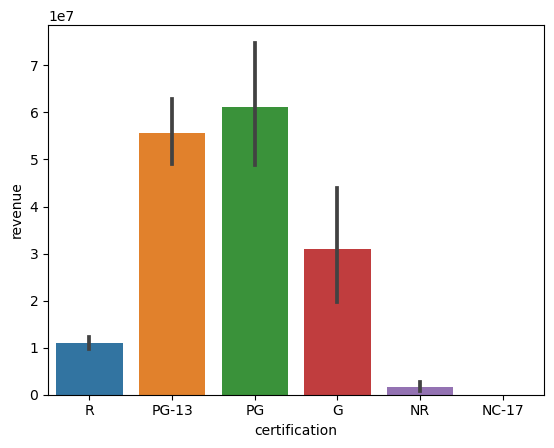

In [16]:
# Let's visualize our revenues per genre
sns.barplot(df, x = 'certification', y = 'revenue');

In [17]:
df['certification'].value_counts()

R        3847
NR       2002
PG-13    1740
PG        810
G         268
NC-17      96
Name: certification, dtype: int64

In [18]:
nn = df.copy()

In [19]:
nn = nn.dropna(subset=['certification', 'revenue'])
nn.head(3)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,origin_country
4,tt0120679,0.0,/s04Ds4xbJU7DzeGVyamccH4LoxF.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.miramax.com/movie/frida,1360.0,en,Frida,"A biography of artist Frida Kahlo, who channel...",15.753,/a4hgR6aKoohB6MHni171jbi9BkU.jpg,"[{'id': 14, 'logo_path': '/m6AHu84oZQxvq7n1rsv...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2002-08-29,56298474.0,123.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Prepare to be seduced.,Frida,0.0,7.422,1915.0,R,NaN
5,tt0120804,0.0,/5pGWjnM62Zs0S1xRf3TDL1Xizr.jpg,"{'id': 17255, 'name': 'Resident Evil Collectio...",33000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...",https://www.sonypictures.com/movies/residentevil,1576.0,en,Resident Evil,"When a virus leaks from a top-secret facility,...",25.030,/1UKNef590A0ZaMnxsscIcWuK1Em.jpg,"[{'id': 248, 'logo_path': None, 'name': 'Impac...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2002-03-15,102984862.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A secret experiment. A deadly virus. A fatal m...,Resident Evil,0.0,6.613,5870.0,R,NaN
6,tt0120912,0.0,/o1l6OCqA3pYDZHIc5L1s7CEzCMv.jpg,"{'id': 86055, 'name': 'Men In Black Collection...",140000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.sonypictures.com/movies/meninblackii,608.0,en,Men in Black II,"Kay and Jay reunite to provide our best, last ...",38.110,/enA22EPyzc2WQ1VVyY7zxresQQr.jpg,"[{'id': 5, 'logo_path': '/tVoHtTipJDUz5cCUib65...","[{'iso_3166_1': 'US', 'name': 'United States o...",2002-07-03,445135288.0,88.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Back in black.,Men in Black II,0.0,6.400,9331.0,PG-13,NaN


In [20]:
## Each group needs to be separated to be analyzed.
groups = {}
## Loop through all unique categories
for i in nn['certification'].unique():
    ## Get series for group and rename
    data = nn.loc[nn['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['R', 'PG-13', 'PG', 'G', 'NR', 'NC-17'])

In [21]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
R,3847.0,0.000000e+00,4388.083702
PG-13,1740.0,0.000000e+00,1937.660661
PG,810.0,3.468316e-215,987.624252
G,268.0,1.150924e-78,358.922144
NR,2002.0,0.000000e+00,4711.370819
NC-17,96.0,4.801249e-35,158.043204


In [22]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
R,3847.0,0.000000e+00,4388.083702,True
PG-13,1740.0,0.000000e+00,1937.660661,True
PG,810.0,3.468316e-215,987.624252,True
G,268.0,1.150924e-78,358.922144,True
NR,2002.0,0.000000e+00,4711.370819,True
NC-17,96.0,4.801249e-35,158.043204,True


In [23]:
# perform the correct hypothesis test
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=100.42765897680043, pvalue=2.6071314563025825e-103)

### With ANOVA giving us a significant result, we can use tukey to perform comparison tests for each group

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = nn['revenue']
labels = nn['certification']

In [25]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,NC-17,-31040379.4672,0.0677,-63329345.4062,1248586.4718,False
G,NR,-29403662.3974,0.0,-47060785.855,-11746538.9399,True
G,PG,30051638.4909,0.0001,10922036.5738,49181240.4081,True
G,PG-13,24522753.773,0.0012,6709375.448,42336132.098,True
G,R,-20025803.0999,0.0113,-37175754.2833,-2875851.9164,True
NC-17,NR,1636717.0698,1.0,-26725589.5253,29999023.6649,False
NC-17,PG,61092017.9581,0.0,31790344.0109,90393691.9053,True
NC-17,PG-13,55563133.2402,0.0,27103286.5444,84022979.936,True
NC-17,R,11014576.3673,0.8736,-17034795.3225,39063948.0572,False
NR,PG,59455300.8883,0.0,48151107.7064,70759494.0703,True


In [26]:
#

##### We can see several significant results between MPAA ratings like PG-13 outperforming R, PG, NR and G. 
##### Not Rated trends poorly against PG and PG-13. While NC-17 doesn't have good revenue, the differences are not considered significant

2. Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

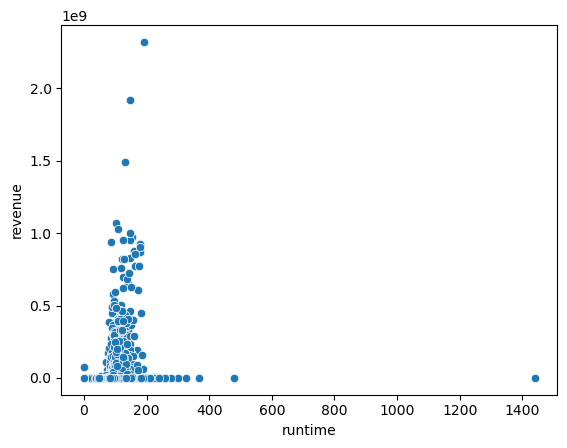

In [27]:
# Visualizing revenue by runtime
sns.scatterplot(df, x='runtime', y='revenue');

In [28]:
# Filtering films into dfs of long and short movies
long_df = df.loc[df['runtime'] >= 150].copy()
short_df = df.loc[df['runtime']<= 90].copy()

In [29]:
# Now defining revenue dfs
long_r = long_df['revenue']
short_r = short_df['revenue']

In [30]:
# Check for outliers in long film revenue
zscores= stats.zscore(long_r)
outliers = abs(zscores)>3
np.sum(outliers)

26

In [31]:
# remove outliers from strength group
long_r = long_r[(np.abs(stats.zscore(long_r)) < 3)]

In [32]:
# Checking same for short films
zscores= stats.zscore(short_r)
np.sum(outliers)

26

In [33]:
# remove outliers
short_r = short_r[(np.abs(stats.zscore(short_r)) < 3)]

In [34]:
# Test for equal variance
result = stats.levene(long_r, short_r)
result

LeveneResult(statistic=597.9927308368573, pvalue=1.11554449364036e-129)

In [35]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(long_r, short_r, equal_var = False)
result

Ttest_indResult(statistic=5.981205503574876, pvalue=3.2525599761601317e-09)

##### With pvalue far less than 0.05 we have a significant result and can reject null

3. Do different certifications trend to different popularity numbers?

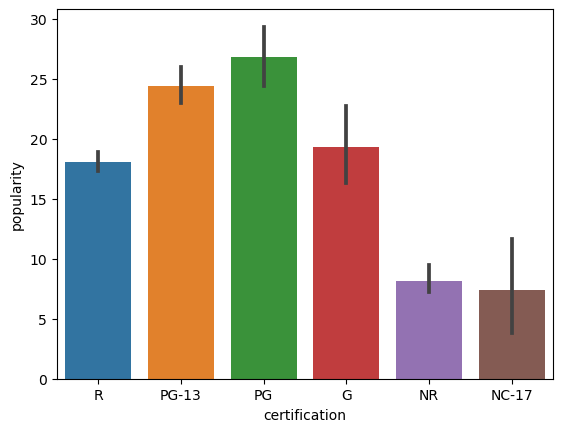

In [36]:
# Making barplot to get a glimpse at correlation
sns.barplot(nn, x='certification', y='popularity');

In [37]:
# There does seem to be correlations though how significant will have to be determined
# It's another ANOVA problem with certifications so we can use our copied df to keep nulls out
groups = {}
## Loop through all unique categories
for i in nn['certification'].unique():
    ## Get series for group and rename
    data = nn.loc[nn['certification']==i,'popularity'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['R', 'PG-13', 'PG', 'G', 'NR', 'NC-17'])

In [38]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
R,3847.0,0.000000e+00,6514.378671
PG-13,1740.0,0.000000e+00,1905.681809
PG,810.0,1.836815e-128,588.245717
G,268.0,2.743380e-44,200.609107
NR,2002.0,0.000000e+00,4817.679774
NC-17,96.0,8.191932e-29,129.343636


In [39]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
R,3847.0,0.000000e+00,6514.378671,True
PG-13,1740.0,0.000000e+00,1905.681809,True
PG,810.0,1.836815e-128,588.245717,True
G,268.0,2.743380e-44,200.609107,True
NR,2002.0,0.000000e+00,4817.679774,True
NC-17,96.0,8.191932e-29,129.343636,True


In [40]:
# perform the correct hypothesis test
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=90.98588278244189, pvalue=1.1900846997014189e-93)

In [41]:
# Definitely significant.
values = nn['popularity']
# labels is same as in first problem

In [42]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,NC-17,-11.8817,0.0035,-21.1486,-2.6148,True
G,NR,-11.1444,0.0,-16.2119,-6.0768,True
G,PG,7.5518,0.0012,2.0616,13.0419,True
G,PG-13,5.1081,0.0503,-0.0043,10.2205,False
G,R,-1.1896,0.9832,-6.1117,3.7324,False
NC-17,NR,0.7374,0.9998,-7.4026,8.8773,False
NC-17,PG,19.4335,0.0,11.0239,27.843,True
NC-17,PG-13,16.9898,0.0,8.8219,25.1577,True
NC-17,R,10.6921,0.0021,2.642,18.7422,True
NR,PG,18.6961,0.0,15.4518,21.9404,True


##### That's a lot to unpack. PG has a significant popularity boost over G, NC-17, and NR. PG-13 enjoys popularity over NC-17 and NR.
##### G as a rating is in the middle and not significantly different except to PG. NC-17 and NR trend poorly, perhaps unsurprisingly.